# Assignment 2: Build a CNN for image recognition.

## Due Date:  March 29, 11:59PM

### Name: [Hamza Shabir]


## Introduction:

1. In this assignment, you will build Convolutional Neural Network to classify CIFAR-10 Images.
2. You can directly load dataset from many deep learning packages.
3. You can use any deep learning packages such as pytorch, keras or tensorflow for this assignment.

## Requirements:

1. You need to load cifar 10 data and split the entire training dataset into training and validation.
2. You will implement a CNN model to classify cifar 10 images with provided structure.
3. You need to plot the training and validation accuracy or loss obtained from above step.
4. Then you can use tuned parameters to train using the entire training dataset.
5. You should report the testing accuracy using the model with complete data.
6. You may try to change the structure (e.g, add BN layer or dropout layer,...) and analyze your findings.

## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

## Batch Normalization (BN)

### Background:

- Batch Normalization is a technique to speed up training and help make the model more stable.
- In simple words, batch normalization is just another network layer that gets inserted between a hidden layer and the next hidden layer. Its job is to take the outputs from the first hidden layer and normalize them before passing them on as the input of the next hidden layer.

- For more detailed information, you may refer to the original paper: https://arxiv.org/pdf/1502.03167.pdf.

### BN Algorithm:

- Input: Values of $x$ over a mini-batch: $\mathbf{B}$ = $\{x_1,..., x_m\};$
- Output: $\{y_i = BN_{\gamma,\beta}(x_i)\}$, $\gamma, \beta$ are learnable parameters

Normalization of the Input:
$$\mu_{\mathbf{B}} = \frac{1}{m}\sum_{i=1}^m x_i$$
$$\sigma_{\mathbf{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathbf{B}})^2$$
$$\hat{x_i} = \frac{x_i - \mu_{\mathbf{B}}}{\sqrt{\sigma_{\mathbf{B}}}^2 + \epsilon}$$
Re-scaling and Offsetting:
$$y_i = \gamma \hat{x_i} + \beta = BN_{\gamma,\beta}(x_i)$$


### Advantages of BN:
1. Improves gradient flow through the network.
2. Allows use of saturating nonlinearities and higher learning rates.
3. Makes weights easier to initialize.
4. Act as a form of regularization and may reduce the need for dropout.

### Implementation:

- The batch normalization layer has already been implemented in many packages. You may simply call the function to build the layer. For example: torch.nn.BatchNorm2d() using pytroch package, keras.layers.BatchNormalization() using keras package.
- The location of BN layer: Please make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

## 1. Data preparation

### 1.1. Load data


In [1]:
# Load Cifar-10 Data
# This is just an example, you may load dataset from other packages.
import keras
import numpy as np
import tensorflow

### If you can not load keras dataset, un-comment these two lines.
#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(np.max(y_train) - np.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels (5 points)

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Implement a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets (5 points)

Randomly partition the 50K training samples to 2 sets: 
* a training set containing 40K samples: x_tr, y_tr
* a validation set containing 10K samples: x_val, y_val


In [3]:
rand_indices = np.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


<img src="network.PNG"/>

- You may use the validation data to tune the hyper-parameters (e.g., learning rate, and optimization algorithm)
- Do NOT use test data for hyper-parameter tuning!!!
- Try to achieve a validation accuracy as high as possible.

In [4]:
# Build the model
from keras import models
from keras import layers

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding="valid" ,input_shape=(32, 32, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding="valid"))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 256)               5

In [5]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers

learning_rate1 = 1e-3 # to be tuned!

model1.compile(loss='categorical_crossentropy',
              optimizer= optimizers.Adagrad(learning_rate=learning_rate1),
              metrics=['acc'])


In [ ]:
# Train the model and store model parameters/loss values
history1 = model1.fit(x_tr, y_tr, batch_size=256, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
157/157 [==============================] - 8s 18ms/step - loss: 5.6346 - acc: 0.2297 - val_loss: 2.9180 - val_acc: 0.2680
Epoch 2/100
157/157 [==============================] - 2s 14ms/step - loss: 2.4145 - acc: 0.3057 - val_loss: 2.3323 - val_acc: 0.3118
Epoch 3/100
157/157 [==============================] - 2s 12ms/step - loss: 2.0822 - acc: 0.3459 - val_loss: 2.1145 - val_acc: 0.3437
Epoch 4/100
157/157 [==============================] - 2s 10ms/step - loss: 1.9215 - acc: 0.3695 - val_loss: 1.9770 - val_acc: 0.3575
Epoch 5/100
157/157 [==============================] - 2s 10ms/step - loss: 1.8179 - acc: 0.3916 - val_loss: 1.9125 - val_acc: 0.3654
Epoch 6/100
157/157 [==============================] - 1s 9ms/step - loss: 1.7460 - acc: 0.4083 - val_loss: 1.8383 - val_acc: 0.3848
Epoch 7/100
157/157 [==============================] - 2s 10ms/step - loss: 1.6899 - acc: 0.4217 - val_loss: 1.7957 - val_acc: 0.3960
Epoch 8/100
157/157 [==============================] - 2s 10ms/

## 3. Plot the training and validation loss curve versus epochs. (5 points)

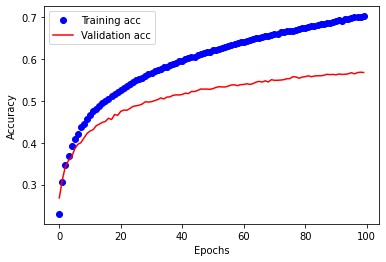

In [7]:
# Plot the accuracy curve
import matplotlib.pyplot as plt
%matplotlib inline

acc = history1.history['acc']
val_acc = history1.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


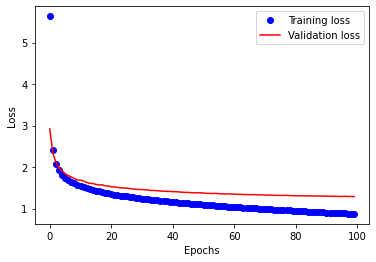

In [8]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model1.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 1.2795 - acc: 0.5705
loss = 1.2794575691223145
accuracy = 0.5705000162124634


## 4. Train (again) and evaluate the model (5 points)

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [10]:
#<Compile your model again (using the same hyper-parameters you tuned above)>
learning_rate2 = 1e-3 # to be tuned!

model1.compile(loss='categorical_crossentropy',
              optimizer= optimizers.Adagrad(learning_rate=learning_rate2),
              metrics=['acc'])


In [11]:
#<Train your model on the entire training set (50K samples)>
history2 = model1.fit(x_train, y_train_vec, batch_size=256, epochs=100)


Epoch 1/100
196/196 [==============================] - 2s 9ms/step - loss: 1.0634 - acc: 0.6448
Epoch 2/100
196/196 [==============================] - 2s 8ms/step - loss: 0.9572 - acc: 0.6719
Epoch 3/100
196/196 [==============================] - 2s 8ms/step - loss: 0.9352 - acc: 0.6810
Epoch 4/100
196/196 [==============================] - 2s 8ms/step - loss: 0.9180 - acc: 0.6866
Epoch 5/100
196/196 [==============================] - 2s 8ms/step - loss: 0.9015 - acc: 0.6910
Epoch 6/100
196/196 [==============================] - 2s 8ms/step - loss: 0.8894 - acc: 0.6964
Epoch 7/100
196/196 [==============================] - 2s 8ms/step - loss: 0.8772 - acc: 0.6999
Epoch 8/100
196/196 [==============================] - 2s 8ms/step - loss: 0.8656 - acc: 0.7062
Epoch 9/100
196/196 [==============================] - 2s 8ms/step - loss: 0.8546 - acc: 0.7085
Epoch 10/100
196/196 [==============================] - 2s 8ms/step - loss: 0.8439 - acc: 0.7128
Epoch 11/100
196/196 [=================

## 5. Evaluate the model on the test set (5 points)

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [12]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model1.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 1.2628 - acc: 0.6244
loss = 1.2627838850021362
accuracy = 0.6244000196456909


## 6. Building model with new structure (25 points)
- In this section, you can build your model with adding new layers (e.g, BN layer or dropout layer, ...).
- If you want to regularize a ```Conv/Dense layer```, you should place a ```Dropout layer``` before the ```Conv/Dense layer```.
- You can try to compare their loss curve and testing accuracy and analyze your findings.
- You need to try at lease two different model structures.

Model 1

In [13]:
# Build the model
from keras import models
from keras import layers

model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(32, 32, 3)))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid'))
model3.add(layers.BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(256, activation='relu'))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

model3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                      

In [14]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers
learning_rate3 = 1e-4 # to be tuned!

model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate3),
              metrics=['acc'])


In [15]:
# Train the model and store model parameters/loss values
history3 = model3.fit(x_tr, y_tr, batch_size=256, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
157/157 [==============================] - 3s 16ms/step - loss: 1.9871 - acc: 0.2701 - val_loss: 1.8389 - val_acc: 0.3378
Epoch 2/100
157/157 [==============================] - 2s 14ms/step - loss: 1.6601 - acc: 0.3889 - val_loss: 1.5621 - val_acc: 0.4363
Epoch 3/100
157/157 [==============================] - 2s 13ms/step - loss: 1.5237 - acc: 0.4424 - val_loss: 1.4286 - val_acc: 0.4795
Epoch 4/100
157/157 [==============================] - 2s 13ms/step - loss: 1.4284 - acc: 0.4792 - val_loss: 1.3417 - val_acc: 0.5187
Epoch 5/100
157/157 [==============================] - 2s 13ms/step - loss: 1.3506 - acc: 0.5105 - val_loss: 1.3103 - val_acc: 0.5306
Epoch 6/100
157/157 [==============================] - 2s 14ms/step - loss: 1.2987 - acc: 0.5292 - val_loss: 1.2418 - val_acc: 0.5553
Epoch 7/100
157/157 [==============================] - 2s 13ms/step - loss: 1.2448 - acc: 0.5507 - val_loss: 1.1981 - val_acc: 0.5739
Epoch 8/100
157/157 [==============================] - 2s 14ms

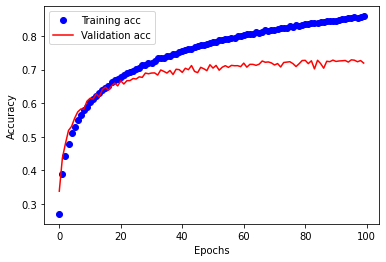

In [16]:
# Plot the accuracy curve
import matplotlib.pyplot as plt
%matplotlib inline

acc = history3.history['acc']
val_acc = history3.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


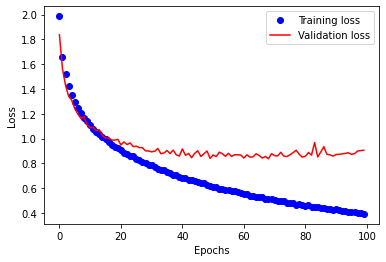

In [17]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model3.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 3ms/step - loss: 0.9030 - acc: 0.7273
loss = 0.9030411243438721
accuracy = 0.7272999882698059


Model 2

In [19]:
# Build the model
from keras import models
from keras import layers

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(32, 32, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(128, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(256, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.BatchNormalization())
model4.add(layers.Dense(10, activation='softmax'))

model4.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 2, 2, 128)       

In [20]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers
learning_rate4 = 1e-4 # to be tuned!

model4.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate4),
              metrics=['acc'])


In [21]:
# Train the model and store model parameters/loss values
history4 = model4.fit(x_tr, y_tr, batch_size=512, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
79/79 [==============================] - 3s 23ms/step - loss: 2.6174 - acc: 0.1472 - val_loss: 2.1622 - val_acc: 0.2235
Epoch 2/100
79/79 [==============================] - 1s 18ms/step - loss: 2.2280 - acc: 0.2140 - val_loss: 2.0156 - val_acc: 0.2410
Epoch 3/100
79/79 [==============================] - 1s 18ms/step - loss: 2.0287 - acc: 0.2717 - val_loss: 1.8611 - val_acc: 0.2968
Epoch 4/100
79/79 [==============================] - 1s 18ms/step - loss: 1.9011 - acc: 0.3079 - val_loss: 1.8025 - val_acc: 0.3305
Epoch 5/100
79/79 [==============================] - 1s 18ms/step - loss: 1.7974 - acc: 0.3421 - val_loss: 1.7120 - val_acc: 0.3731
Epoch 6/100
79/79 [==============================] - 1s 18ms/step - loss: 1.7346 - acc: 0.3652 - val_loss: 1.6607 - val_acc: 0.3959
Epoch 7/100
79/79 [==============================] - 1s 18ms/step - loss: 1.6659 - acc: 0.3917 - val_loss: 1.5673 - val_acc: 0.4307
Epoch 8/100
79/79 [==============================] - 1s 18ms/step - loss: 1.

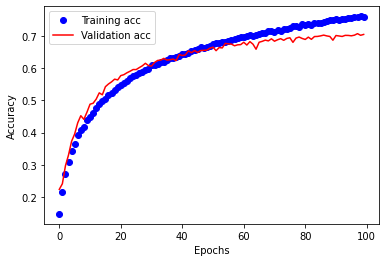

In [22]:
# Plot the accuracy curve
import matplotlib.pyplot as plt
%matplotlib inline

acc = history4.history['acc']
val_acc = history4.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

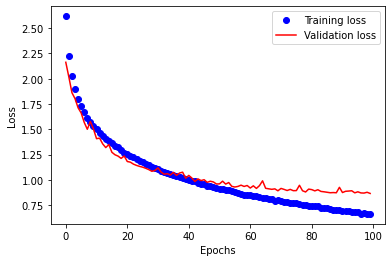

In [23]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model4.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.8508 - acc: 0.7090
loss = 0.850807785987854
accuracy = 0.7089999914169312


Model 3

In [25]:
# Build the model
from keras import models
from keras import layers

model5 = models.Sequential()
model5.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(32, 32, 3)))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Conv2D(128, (3, 3), activation='relu', padding='valid'))
model5.add(layers.BatchNormalization())
model5.add(layers.MaxPooling2D((2, 2)))
model5.add(layers.Flatten())
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dense(256, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dense(512, activation='relu'))
model5.add(layers.BatchNormalization())
model5.add(layers.Dense(10, activation='softmax'))

model5.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                      

In [26]:
# Define model optimizer and loss function
from tensorflow.keras import optimizers
learning_rate5 = 1e-4 # to be tuned!

model5.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=learning_rate5),
              metrics=['acc'])


In [27]:
# Train the model and store model parameters/loss values
history5 = model5.fit(x_tr, y_tr, batch_size=256, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
157/157 [==============================] - 4s 16ms/step - loss: 2.2506 - acc: 0.2321 - val_loss: 1.8973 - val_acc: 0.3228
Epoch 2/100
157/157 [==============================] - 2s 14ms/step - loss: 1.8802 - acc: 0.3235 - val_loss: 1.6704 - val_acc: 0.3826
Epoch 3/100
157/157 [==============================] - 2s 14ms/step - loss: 1.7292 - acc: 0.3706 - val_loss: 1.6105 - val_acc: 0.4112
Epoch 4/100
157/157 [==============================] - 2s 14ms/step - loss: 1.6308 - acc: 0.4037 - val_loss: 1.5141 - val_acc: 0.4520
Epoch 5/100
157/157 [==============================] - 2s 14ms/step - loss: 1.5464 - acc: 0.4372 - val_loss: 1.4274 - val_acc: 0.4890
Epoch 6/100
157/157 [==============================] - 2s 14ms/step - loss: 1.4681 - acc: 0.4672 - val_loss: 1.3725 - val_acc: 0.5128
Epoch 7/100
157/157 [==============================] - 2s 14ms/step - loss: 1.4191 - acc: 0.4837 - val_loss: 1.3392 - val_acc: 0.5216
Epoch 8/100
157/157 [==============================] - 2s 13ms

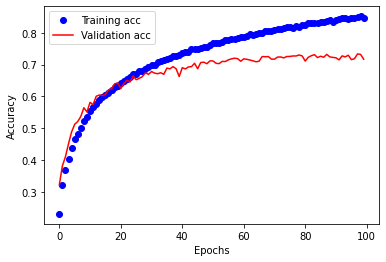

In [28]:
# Plot the accuracy curve
import matplotlib.pyplot as plt
%matplotlib inline

acc = history5.history['acc']
val_acc = history5.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


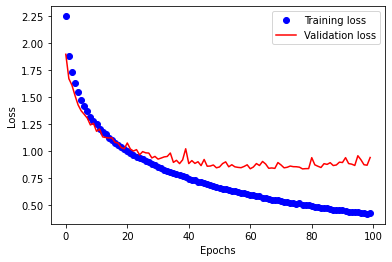

In [29]:
# Plot the loss curve
import matplotlib.pyplot as plt
%matplotlib inline

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
# Evaluate your model performance (testing accuracy) on testing data.
loss_and_acc = model5.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.9291 - acc: 0.7182
loss = 0.9291126132011414
accuracy = 0.7182000279426575
